In [1]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import nibabel as nb
import hrf_tools
import hcp_utils as hcp
from analysis import plot_59k_results

import matplotlib.pyplot as plt


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [2]:
subject=100610
feature='rms'
n_movies=4
scaler = StandardScaler()

In [3]:
i=0
stim = ['tfMRI_MOVIE1_7T_AP','tfMRI_MOVIE2_7T_PA','tfMRI_MOVIE3_7T_PA','tfMRI_MOVIE4_7T_AP']
stim_feat = ['7T_MOVIE1_CC1_v2', '7T_MOVIE2_HO1_v2', '7T_MOVIE3_CC2_v2', '7T_MOVIE4_HO2_v2']
    
im_file = f'../sourcedata/data/HCP_7T_movie_FIX/brain/HCP_7T_movie_FIX/100610/MNINonLinear/Results/{stim[i]}/{stim[i]}_Atlas_1.6mm_MSMAll_hp2000_clean.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y = scaler.fit_transform(img_y)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


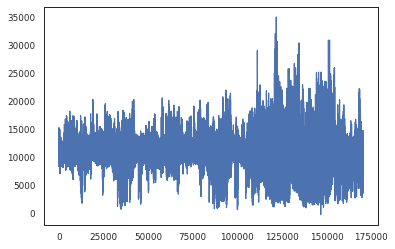

In [4]:
plt.plot(img_y[0,:])

In [5]:
img_y.shape

(921, 170494)

In [6]:
img_y_mean = img_y.mean(axis=0)
Y_mean = Y.mean(axis=0)

In [7]:
vertex_info = hcp.get_HCP_vertex_info(img)

In [18]:
import numpy as np
import nibabel as nb
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from nilearn_plotting_custom import plot_surf
from PIL import Image
from PIL import ImageDraw
import npp
import hcp_utils as hcp
from hcp_tools import load_flatmaps_59k
from hcp_tools import load_meshes
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set("paper", "white")
#%matplotlib inline
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'


def plot_59k_results(scores,score_type,vertex_info,subject,feature,title,scratch_dir):
    if score_type == 'r2':
        v=[0,0.1]
        threshold=None
        symmetric_cmap=False
        cmap='inferno'
    if score_type == 'p':
        v=[0,0.05]
        symmetric_cmap=False
        cmap='inferno'
    if score_type == 'z':
        v=[-10,10]
        threshold=3
        symmetric_cmap=True
        cmap='cold_hot'
    if score_type == 'd':
        v=[0,10]
        threshold=3
        symmetric_cmap=True
        cmap='inferno'
    if score_type == 'raw':
        v=[-10,10]
        threshold=0.8
        symmetric_cmap=True
        cmap='cold_hot'
    fig_path=f'../outputs/figures/HCP_7T/{score_type}'
    save_dir=f'{fig_path}/{title}{str(subject)}_{feature}'
    temp_dir=f'{scratch_dir}/{title}{str(subject)}_{feature}'
    if not os.path.exists(temp_dir):
        os.mkdir(temp_dir)
    flatmeshes=load_flatmaps_59k() #load flatmaps
    surf_path_msm = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.L.inflated_1.6mm_MSMAll.59k_fs_LR.surf.gii'
    mesh59k_msm = load_meshes(example_filename=surf_path_msm) #load other meshes
    # get data from results in plotting format
    score_cortex_dataL = hcp.left_cortex_data(scores, fill=0, vertex_info=vertex_info)
    score_cortex_dataR = hcp.right_cortex_data(scores, fill=0, vertex_info=vertex_info)
    # sulcal depth paths
    sulc_left = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.L.sulc.59k_fs_LR.shape.gii'
    sulc_right = '../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/MNINonLinear/fsaverage_LR59k/100610.R.sulc.59k_fs_LR.shape.gii'
    # params for view to plot
    params = [('flat_L',score_cortex_dataL,flatmeshes.flat_left,sulc_left,'left'),\
     ('flat_R',score_cortex_dataR,flatmeshes.flat_right,sulc_right,'right'),\
     ('vinf_L',score_cortex_dataL,mesh59k_msm.very_inflated_left,sulc_left,'left'),\
     ('vinf_R',score_cortex_dataR,mesh59k_msm.very_inflated_right,sulc_right,'right'),\
    ]
    # plot each hemi and mesh, save to outputs dir
    for name, data, mesh, sulc, hemi in params:
        plot_surf(mesh,\
                data, \
                  cmap=cmap,symmetric_cmap=symmetric_cmap, avg_method='median',#figure=fig,\
                bg_map=sulc, colorbar=True, vmin=v[0], vmax=v[1], threshold=threshold, hemi=hemi, \
                data_alpha=np.where(data>0,1,0),\
                data_remove=np.zeros(data.shape),output_file=f'{temp_dir}/{name}.png')

    #combine saved maps into one with PIL
    area = (75, 140, 635, 560) #area to crop from each image

    img = Image.open(f'{temp_dir}/flat_L.png')
    fL = img.crop(area)
    w,h = img.size
    c_area = (690, 0, w-10, h) # area of colorbar to crop
    cbar = img.crop(c_area)

    img = Image.open(f'{temp_dir}/flat_R.png')
    fR = img.crop(area)

    img = Image.open(f'{temp_dir}/vinf_L.png')
    cropped = img.crop(area)
    iL=cropped.transpose(Image.FLIP_LEFT_RIGHT)

    img = Image.open(f'{temp_dir}/vinf_R.png')
    iR = img.crop(area)

    w,h=iR.size

    new_im = Image.new('RGB', ( (w*2)+70 , h*2) ,(255, 255, 255, 1))
    new_im.paste(fL,(0,h))
    new_im.paste(fR,(w,h))
    new_im.paste(iL,(0,0))
    new_im.paste(iR,(w,0))
    new_im.paste(cbar,(w*2,int(round(h/4))))

    w,h=new_im.size

    draw = ImageDraw.Draw(new_im)
    draw.text((0,0),f"{title}_{subject}_{feature}",(0,0,0))
    new_im.save(f'{temp_dir}/../out/{title}_{subject}_{feature}.png')
    #new_im.save(f'{fig_path}/{title}_{subject}_{feature}.png')

In [ ]:
#scores,score_type,vertex_info,subject,feature,title
for i in np.arange(Y.shape[0]):
    if not os.path.isfile(f'/scratch/scratch/Mon/jsmentch/out/raw{i}_100610_rms.png'):
        plot_59k_results(Y[i,:]-Y_mean,'raw',vertex_info,subject,'rms',f'raw{i}','/scratch/scratch/Mon/jsmentch')

Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.31011722 0.31053869 0.31296143 ... 0.6526143  0.65336076 0.66724433]
[0.31377436 0.31407339 0.31721119 ... 0.64368389 0.65214994 0.65596457]
[0.31011722 0.31053869 0.31296143 ... 0.6526143  0.65336076 0.66724433]
[0.31377436 0.31407339 0.31721119 ... 0.64368389 0.65214994 0.65596457]
Cannot load file ../sourcedata/data/human-connectome-project-openaccess/HCP1200/100610/T1w/fsaverage_LR59k/100610.sulc_1.6mm_MSMAll.59k_fs_LR.dscalar.nii with sulcal depth data
[0.30480701 0.30887259 0.31118108 ... 0.66167098 0.67207607 0.68754291]
[0.29359599 0.30549475 0.31463589 ... 0.65201346 0.65549015 0.65965353]
[0.30480701 0.30887259 0.31118108 ... 0.66167098 0.67207607 0.68754291]
[0.29359599 0.30549475 0.31463589 ... 0.65201346 0.65549015 0.65965353]
Cannot load file ../sourcedata/data/human-connectome-project-openacces